In [1]:
import pytensor
import pytensor.tensor as pt
import pymc as pm
from pymc.pytensorf import collect_default_updates
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from pytensor import function
from pytensor.printing import Print

%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Generate artifical data
n_steps = 100
rng = np.random.default_rng(1234) # for reproducibility
x0_true = rng.normal(size=1) # initial value
true_sigma = abs(rng.normal(scale=0.5, size=1)); print("true sigma:", true_sigma)
true_irreg = abs(rng.normal(scale=0.5, size=1)); print("true irreg:", true_irreg)
grw_innovations = rng.normal(scale=true_sigma, size=(100,))
data = rng.normal(np.r_[x0_true, grw_innovations].cumsum()[1:], true_irreg)



true sigma: [0.03204996]
true irreg: [0.37044565]


In [2]:

# Helper function for pm.CustomDist
def statespace_dist(mu_init, sigma_level, size):

    def grw_step(mu_tm1, sigma_level):
        mu_t = mu_tm1 + pm.Normal.dist(sigma=sigma_level)
        return mu_t, collect_default_updates(outputs=[mu_t])

    mu, updates = pytensor.scan(fn=grw_step, 
                                outputs_info=[{"initial": mu_init}], # looping over this
                                non_sequences=[sigma_level], # constant
                                n_steps=n_steps,
                                name='statespace',
                                strict=True)

    return mu

# PyMC Model
coords = {'time':np.arange(n_steps)}

with pm.Model(coords=coords) as model:           
    y_data = pm.MutableData('y_data', data, dims=['time'])  # can we find the underlying parameters?	

    mu_init = pm.Normal('mu_init', mu=0, sigma=1)
    sigma_level = pm.HalfNormal('sigma_level', sigma=1)
    sigma_irreg = pm.HalfNormal('sigma_irreg', sigma=1)

    mu = pm.CustomDist('hidden_states', 
                          mu_init,
                          sigma_level,
                          dist=statespace_dist,
                          dims=['time'])
    
    y_hat = pm.Normal('y_hat', mu, sigma_irreg, observed=y_data, dims=['time'])    
    
    idata = pm.sample()

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_init, sigma_level, sigma_irreg, hidden_states]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 190 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [3]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [y_hat]


Output()

In [4]:
idata.posterior_predictive

<xarray.Dataset> Size: 3MB
Dimensions:  (chain: 4, draw: 1000, time: 100)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * time     (time) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
Data variables:
    y_hat    (chain, draw, time) float64 3MB -1.663 -1.19 ... -0.7904 -1.235
Attributes:
    created_at:                 2024-09-16T11:24:12.650191+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

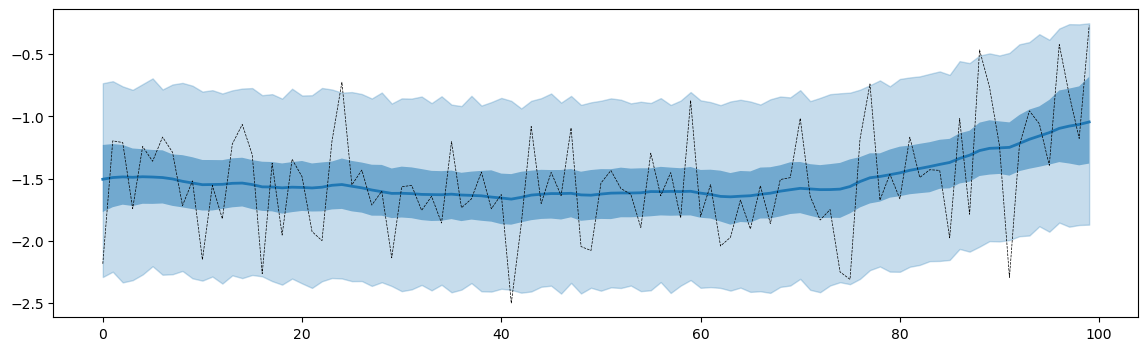

In [5]:
fig, ax = plt.subplots(figsize=(14, 4))
x_grid = coords['time']

mu_data = idata.posterior.hidden_states
mu_hdi = az.hdi(mu_data).hidden_states
ax.plot(x_grid, mu_data.mean(dim=['chain', 'draw']), lw=2)
ax.fill_between(x_grid, *mu_hdi.values.T, alpha=0.5)


post_data = idata.posterior_predictive.y_hat
hdi = az.hdi(post_data).y_hat
# ax.plot(x_grid, post_data.mean(dim=['chain', 'draw']))
ax.fill_between(x_grid, *hdi.values.T, alpha=0.25, color='tab:blue')
ax.plot(data, color='k', ls='--', lw=0.5)